


Epoch 1/20
842/842 [==============================] - 486s 524ms/step - loss: 0.1284 - accuracy: 0.9253 - val_loss: 0.0098 - val_accuracy: 0.9978
Epoch 2/20
842/842 [==============================] - 436s 518ms/step - loss: 0.0058 - accuracy: 0.9988 - val_loss: 0.0041 - val_accuracy: 0.9990
Epoch 3/20
842/842 [==============================] - 436s 518ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 0.0044 - val_accuracy: 0.9991
Epoch 4/20
842/842 [==============================] - 437s 519ms/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 0.0021 - val_accuracy: 0.9997
Epoch 5/20
842/842 [==============================] - 436s 518ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0032 - val_accuracy: 0.9991
Epoch 6/20
842/842 [==============================] - 437s 519ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0019 - val_accuracy: 0.9997
Epoch 7/20
842/842 [==============================] - 436s 518ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.009

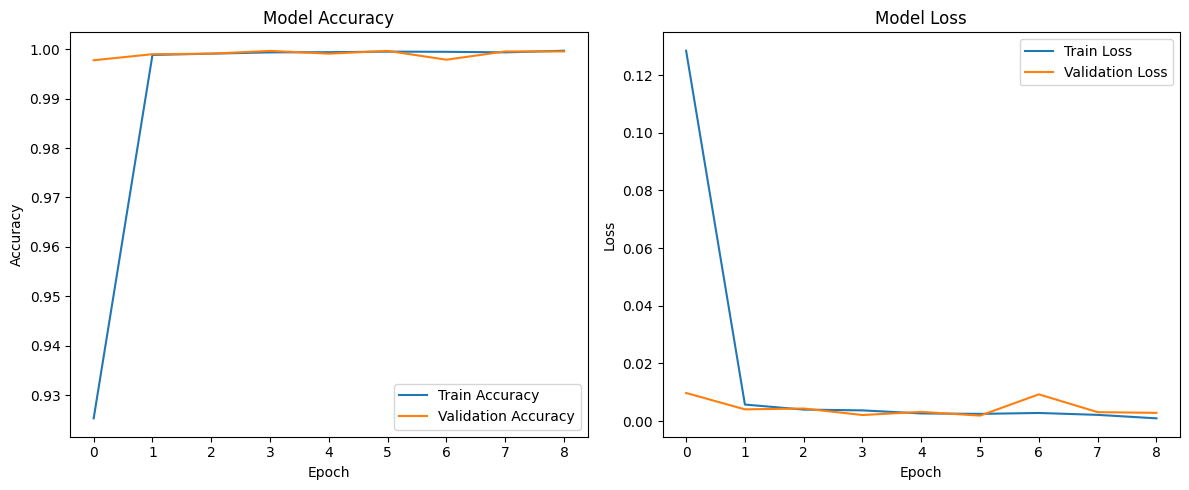

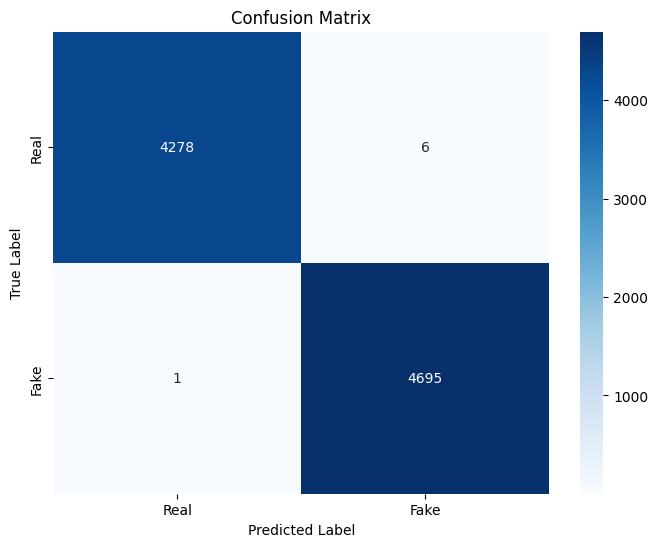


Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      4284
        Fake       1.00      1.00      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizerFast
from transformers import BertConfig, TFBertForSequenceClassification

fake_df = pd.read_csv("/kaggle/input/fake-news-detection/fake.csv")
true_df = pd.read_csv("/kaggle/input/fake-news-detection/true.csv")

fake_df['fake'] = 1
true_df['fake'] = 0


df = pd.concat([fake_df[['text', 'fake']], true_df[['text', 'fake']]], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


df_texts = df['text'].tolist()
df_labels = df['fake'].tolist()

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_texts, df_labels, test_size=0.4, random_state=42, stratify=df_labels
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

with open("train_text.txt", "w", encoding="utf-8") as f:
    for text in train_texts:
        f.write(text + "\n")

custom_tokenizer = BertWordPieceTokenizer(lowercase=True)
custom_tokenizer.train(files=["train_text.txt"], vocab_size=10000, min_frequency=2)


os.makedirs("custom_tokenizer", exist_ok=True)
custom_tokenizer.save_model("custom_tokenizer/")


tokenizer = BertTokenizerFast.from_pretrained("custom_tokenizer/")


config = BertConfig(
    vocab_size=10000,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    max_position_embeddings=512,
    type_vocab_size=2,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    num_labels=2
)

model = TFBertForSequenceClassification(config)


def tokenize_texts(texts, labels):
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='tf'
    )
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), tf.convert_to_tensor(labels)))
    return dataset.shuffle(100).batch(32)

train_dataset = tokenize_texts(train_texts, train_labels)
val_dataset = tokenize_texts(val_texts, val_labels)
test_dataset = tokenize_texts(test_texts, test_labels)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[early_stopping])


loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


y_pred = []
y_true = []

for batch in test_dataset:
    inputs, labels = batch
    logits = model(inputs, training=False).logits
    preds = tf.argmax(logits, axis=1).numpy()
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))



===== EXPLAINING A REAL NEWS ARTICLE =====

Model prediction: Real news (probability: 0.9999)
Explanation (top contributing words):
• "political" contributes 0.0000 toward REAL
• "by" contributes 0.0000 toward REAL
• "Reuters" contributes 0.0000 toward FAKE
• "BERLIN" contributes 0.0000 toward REAL
• "United" contributes 0.0000 toward REAL
• "international" contributes 0.0000 toward REAL
• "on" contributes 0.0000 toward REAL
• "fired" contributes 0.0000 toward REAL
• "efforts" contributes 0.0000 toward REAL
• "acts" contributes 0.0000 toward REAL


<Figure size 1000x600 with 0 Axes>

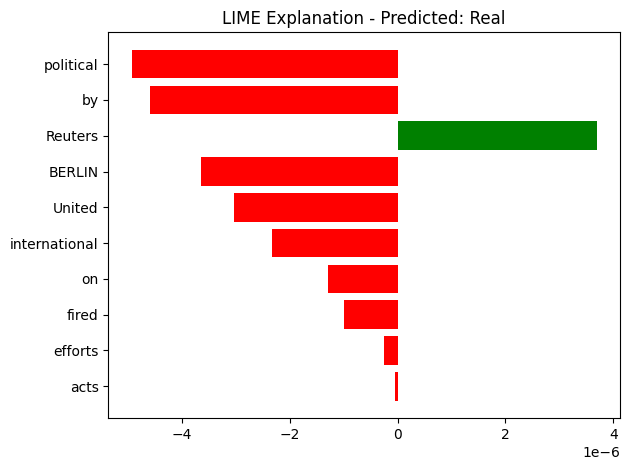


===== EXPLAINING A FAKE NEWS ARTICLE =====

Model prediction: Fake news (probability: 0.9999)
Explanation (top contributing words):
• "forward" contributes 0.0000 toward FAKE
• "we" contributes 0.0000 toward FAKE
• "illegal" contributes 0.0000 toward REAL
• "really" contributes 0.0000 toward REAL
• "compromise" contributes 0.0000 toward FAKE
• "pull" contributes 0.0000 toward REAL
• "CHUCK" contributes 0.0000 toward FAKE
• "taking" contributes 0.0000 toward FAKE
• "re" contributes 0.0000 toward FAKE
• "someone" contributes 0.0000 toward REAL


<Figure size 1000x600 with 0 Axes>

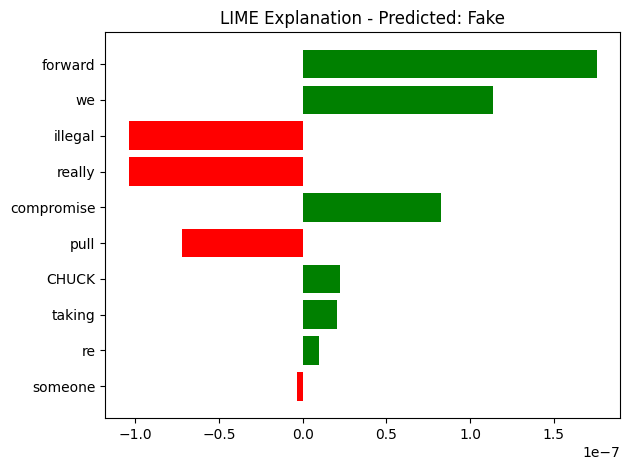

In [ ]:
import numpy as np
import tensorflow as tf
from lime.lime_text import LimeTextExplainer
from transformers import BertTokenizerFast
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

max_length = 128

class BERTWrapper:
    def __init__(self, model, tokenizer, max_length=128, batch_size=8):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.batch_size = batch_size
    
    def predict_proba(self, texts):
        if isinstance(texts, str):
            texts = [texts]
        all_probs = []
        for i in range(0, len(texts), self.batch_size):
            batch = texts[i:i + self.batch_size]
            inputs = self.tokenizer(
                batch,
                max_length=self.max_length,
                padding="max_length",
                truncation=True,
                return_tensors="tf"
            )
            outputs = self.model(inputs, training=False).logits
            probs = tf.nn.softmax(outputs, axis=1).numpy()
            all_probs.extend(probs)
        return np.array(all_probs)


fake_df = pd.read_csv("/kaggle/input/fake-news-detection/fake.csv")
true_df = pd.read_csv("/kaggle/input/fake-news-detection/true.csv")
fake_df['fake'] = 1
true_df['fake'] = 0
df = pd.concat([fake_df[['text', 'fake']], true_df[['text', 'fake']]], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df_texts = df['text'].tolist()
df_labels = df['fake'].tolist()
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_texts, df_labels, test_size=0.4, random_state=42, stratify=df_labels
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)
test_data = pd.DataFrame({'text': test_texts, 'fake': test_labels})

wrapped_model = BERTWrapper(model, tokenizer, max_length=max_length, batch_size=8)
explainer = LimeTextExplainer(class_names=["Real", "Fake"])

def explain_bert_with_lime(text_to_explain, num_features=10, num_samples=300):
    explanation = explainer.explain_instance(
        text_to_explain,
        wrapped_model.predict_proba,
        num_features=num_features,
        num_samples=num_samples
    )
    probs = wrapped_model.predict_proba([text_to_explain])[0]
    pred_class = "Fake" if np.argmax(probs) == 1 else "Real"
    confidence = probs[1] if pred_class == "Fake" else probs[0]
    print(f"\nModel prediction: {pred_class} news (probability: {confidence:.4f})")
    print("Explanation (top contributing words):")
    for word, weight in explanation.as_list():
        direction = "FAKE" if weight > 0 else "REAL"
        print(f"• \"{word}\" contributes {abs(weight):.4f} toward {direction}")
    plt.figure(figsize=(10, 6))
    explanation.as_pyplot_figure()
    plt.title(f"LIME Explanation - Predicted: {pred_class}")
    plt.tight_layout()
    plt.show()
    return explanation

real_example = test_data[test_data["fake"] == 0]["text"].iloc[0]
fake_example = test_data[test_data["fake"] == 1]["text"].iloc[0]
print("===== EXPLAINING A REAL NEWS ARTICLE =====")
explain_bert_with_lime(real_example)
print("\n===== EXPLAINING A FAKE NEWS ARTICLE =====")
explain_bert_with_lime(fake_example)

Some layers from the model checkpoint at bert_from_scratch_fake_news_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at bert_from_scratch_fake_news_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 3/3 [00:35<00:00,  8.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [00:54, 18.27s/it]                       


shap_values.values shape: (3,)
shap_values.values[0] shape: (332, 2)
shap_values.base_values shape: (3, 2)
Predicted probabilities for first sample: Real (class 0) = 0.0001, Fake (class 1) = 0.9999
Plotting SHAP Waterfall plot for **Real News** class (class 0).


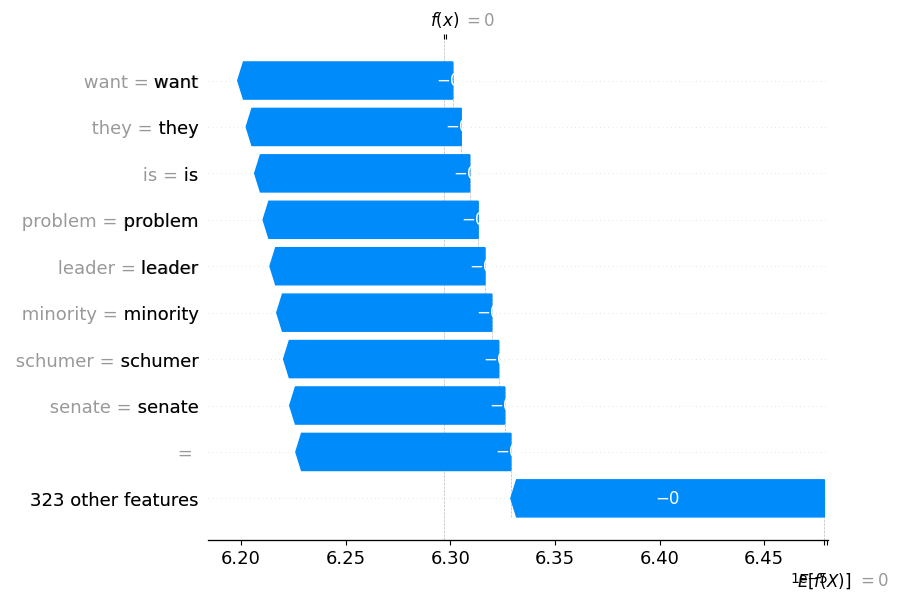

In [ ]:
import shap
import transformers
import tensorflow as tf
import numpy as np
import copy


model = transformers.TFBertForSequenceClassification.from_pretrained("bert_from_scratch_fake_news_model")
tokenizer = transformers.BertTokenizer.from_pretrained("bert_from_scratch_fake_news_model")

sample_texts = test_data['text'].tolist()[:3]

def predict_proba(texts):
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    texts = [str(t) for t in texts]

    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors='tf'
    )
    if 'token_type_ids' not in encodings:
        encodings['token_type_ids'] = tf.zeros_like(encodings['input_ids'])

    outputs = model(encodings)
    logits = outputs.logits
    return tf.nn.softmax(logits, axis=1).numpy()

explainer = shap.Explainer(predict_proba, tokenizer)
shap_values = explainer(sample_texts)

print("shap_values.values shape:", shap_values.values.shape)
print("shap_values.values[0] shape:", shap_values.values[0].shape)
print("shap_values.base_values shape:", np.shape(shap_values.base_values))


probs = predict_proba([sample_texts[0]])
print(f"Predicted probabilities for first sample: Real (class 0) = {probs[0][0]:.4f}, Fake (class 1) = {probs[0][1]:.4f}")


class_to_plot = 0
shap_values_class = copy.deepcopy(shap_values[0])  
shap_values_class.values = shap_values_class.values[:, class_to_plot]
shap_values_class.base_values = shap_values_class.base_values[class_to_plot]

if class_to_plot == 1:
    print("Plotting SHAP Waterfall plot for **Fake News** class (class 1).")
else:
    print("Plotting SHAP Waterfall plot for **Real News** class (class 0).")

shap.plots.waterfall(shap_values_class)


Some layers from the model checkpoint at bert_from_scratch_fake_news_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at bert_from_scratch_fake_news_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 3/3 [00:35<00:00,  8.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [00:54, 18.02s/it]                       


shap_values.values shape: (3,)
shap_values.values[0] shape: (332, 2)
shap_values.base_values shape: (3, 2)
Predicted probabilities for first sample: Real (class 0) = 0.0001, Fake (class 1) = 0.9999
Plotting SHAP Waterfall plot for **Fake News** class (class 1).


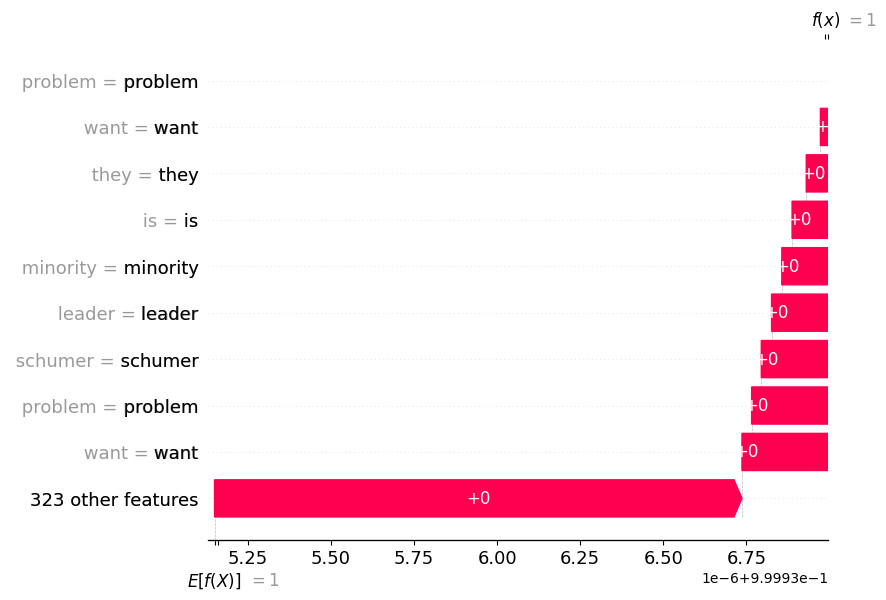

In [ ]:
import shap
import transformers
import tensorflow as tf
import numpy as np
import copy


model = transformers.TFBertForSequenceClassification.from_pretrained("bert_from_scratch_fake_news_model")
tokenizer = transformers.BertTokenizer.from_pretrained("bert_from_scratch_fake_news_model")

sample_texts = test_data['text'].tolist()[:3]

def predict_proba(texts):
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    texts = [str(t) for t in texts]

    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors='tf'
    )
    if 'token_type_ids' not in encodings:
        encodings['token_type_ids'] = tf.zeros_like(encodings['input_ids'])

    outputs = model(encodings)
    logits = outputs.logits
    return tf.nn.softmax(logits, axis=1).numpy()

explainer = shap.Explainer(predict_proba, tokenizer)
shap_values = explainer(sample_texts)

print("shap_values.values shape:", shap_values.values.shape)
print("shap_values.values[0] shape:", shap_values.values[0].shape)
print("shap_values.base_values shape:", np.shape(shap_values.base_values))


probs = predict_proba([sample_texts[0]])
print(f"Predicted probabilities for first sample: Real (class 0) = {probs[0][0]:.4f}, Fake (class 1) = {probs[0][1]:.4f}")


class_to_plot = 1
shap_values_class = copy.deepcopy(shap_values[0])  
shap_values_class.values = shap_values_class.values[:, class_to_plot]
shap_values_class.base_values = shap_values_class.base_values[class_to_plot]

if class_to_plot == 1:
    print("Plotting SHAP Waterfall plot for **Fake News** class (class 1).")
else:
    print("Plotting SHAP Waterfall plot for **Real News** class (class 0).")

shap.plots.waterfall(shap_values_class)


In [ ]:

import pandas as pd
import numpy as np


y_pred = []
y_true = []
test_texts_full = []

for batch in test_dataset:
    inputs, labels = batch
    logits = model(inputs, training=False).logits
    preds = tf.argmax(logits, axis=1).numpy()
    y_pred.extend(preds)
    y_true.extend(labels.numpy())


y_pred = np.array(y_pred)
y_true = np.array(y_true)


results_df = pd.DataFrame({
    'text': test_texts[:len(y_pred)],  
    'true_label': y_true,
    'predicted_label': y_pred
})


results_df['true_label_name'] = results_df['true_label'].map({0: 'Real', 1: 'Fake'})
results_df['predicted_label_name'] = results_df['predicted_label'].map({0: 'Real', 1: 'Fake'})


misclassified = results_df[results_df['true_label'] != results_df['predicted_label']].copy()


misclassified = misclassified.reset_index()
misclassified['original_index'] = misclassified['index']


print("Misclassified Samples Analysis")
print("=" * 80)
print(f"Total test samples: {len(results_df)}")
print(f"Misclassified samples: {len(misclassified)}")
print(f"Accuracy: {(len(results_df) - len(misclassified)) / len(results_df) * 100:.2f}%")
print("\n" + "=" * 80)


print(f"{'Index':<6} {'Text Snippet':<50} {'True Label':<12} {'Predicted Label'}")
print("-" * 80)

for idx, row in misclassified.head(5).iterrows():  
    
    text_snippet = row['text'][:47] + "..." if len(row['text']) > 50 else row['text']
    print(f"{row['original_index']:<6} {text_snippet:<50} {row['true_label_name']:<12} {row['predicted_label_name']}")

print("\n" + "=" * 80)


print("\nMisclassification Breakdown:")
fake_as_real = len(misclassified[misclassified['true_label'] == 1])  
real_as_fake = len(misclassified[misclassified['true_label'] == 0])  

print(f"Fake news predicted as Real: {fake_as_real}")
print(f"Real news predicted as Fake: {real_as_fake}")


misclassified[['original_index', 'text', 'true_label_name', 'predicted_label_name']].to_csv(
    'misclassified_samples.csv', index=False
)
print(f"\nMisclassified samples saved to 'misclassified_samples.csv'")


print("\n" + "=" * 80)
print("Sample Misclassified Texts (Full):")
print("=" * 80)

for idx, row in misclassified.head(3).iterrows():
    print(f"\nIndex {row['original_index']}:")
    print(f"True Label: {row['true_label_name']}")
    print(f"Predicted Label: {row['predicted_label_name']}")
    print(f"Text: {row['text'][:200]}..." if len(row['text']) > 200 else f"Text: {row['text']}")
    print("-" * 40)

Misclassified Samples Analysis
Total test samples: 8980
Misclassified samples: 7
Accuracy: 99.92%

Index  Text Snippet                                       True Label   Predicted Label
--------------------------------------------------------------------------------
265    As is normal these days for Trump rallies, prot... Real         Fake
833    A health care executive cheated Medicare out of... Fake         Real
2093   NAIROBI (Reuters) - Kenya s police service said... Real         Fake
3197   TURNBERRY, Scotland (Reuters) - U.S. presidenti... Real         Fake
3221   WELLINGTON (Reuters) - The final opinion poll b... Real         Fake


Misclassification Breakdown:
Fake news predicted as Real: 1
Real news predicted as Fake: 6

Misclassified samples saved to 'misclassified_samples.csv'

Sample Misclassified Texts (Full):

Index 265:
True Label: Real
Predicted Label: Fake
Text: As is normal these days for Trump rallies, protesters and Trump supporters clashed outside just such a rall